# Simulating orbital dynamics with an HNN
Sam Greydanus

The idea is to use Newton's law to get accelerations. Then we pass the velocities and accelerations to the ODE solver, which uses them to update the positions and velocities (respectively) of the bodies.
$$
m_i a_i = G m_i \sum_{j\neq i}^N \frac{r_j-r_i}{||r_j-r_i||^3}
$$
We'll try and train an Hamiltonian NN and a baseline NN to model this system

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch, time, sys
import numpy as np
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-orbits'
sys.path.append(EXPERIMENT_DIR)

from nn_models import MLP
from hnn import HNN
from utils import L2_loss, to_pickle, from_pickle
from data import get_dataset, coords2state, get_orbit, random_config
from data import potential_energy, kinetic_energy, total_energy

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'

def get_args():
    return {'input_dim': 2*4, # two bodies, each with q_x, q_y, p_z, p_y
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'input_noise': 0.,
         'batch_size': 200,
         'nonlinearity': 'tanh',
         'total_steps': 1500,
         'field_type': 'solenoidal',
         'print_every': 200,
         'verbose': True,
         'name': '2body',
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Visualize one example from dataset

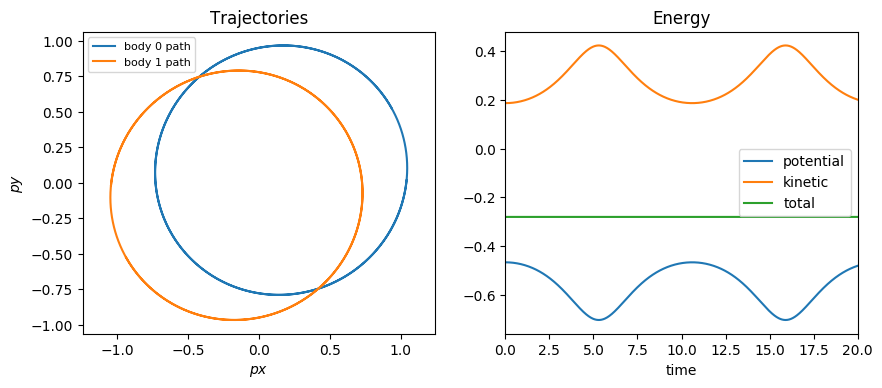

In [3]:
args = ObjectView(get_args())
np.random.seed(2)
state = random_config()
orbit, settings = get_orbit(state, t_points=1000, t_span = [0, 20], rtol = 1e-10)

# draw trajectories
fig = plt.figure(figsize=[10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$px$') ; plt.ylabel('$py$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])

plt.show()
fig.savefig('{}/orbits-dataset.{}'.format(args.fig_dir, FORMAT))

## Load models

In [4]:
def load_model(args, baseline=False):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
            field_type=args.field_type, baseline=baseline)
    
    case = 'baseline' if baseline else 'hnn'
    path = "{}/{}-orbits-{}.tar".format(args.save_dir, args.name, case)
    model.load_state_dict(torch.load(path))
    return model

args = ObjectView(get_args())
base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)

## What has the baseline learned?

In [5]:
# for integrating a vector field parameterized by a NN or HNN
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,2).T
    return deriv.reshape(-1)

### Integrate trajectories

In [6]:
np.random.seed(2)
t_points = 2000
t_span = [0,50]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update(t, y0, base_model)
base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

### Draw trajectories

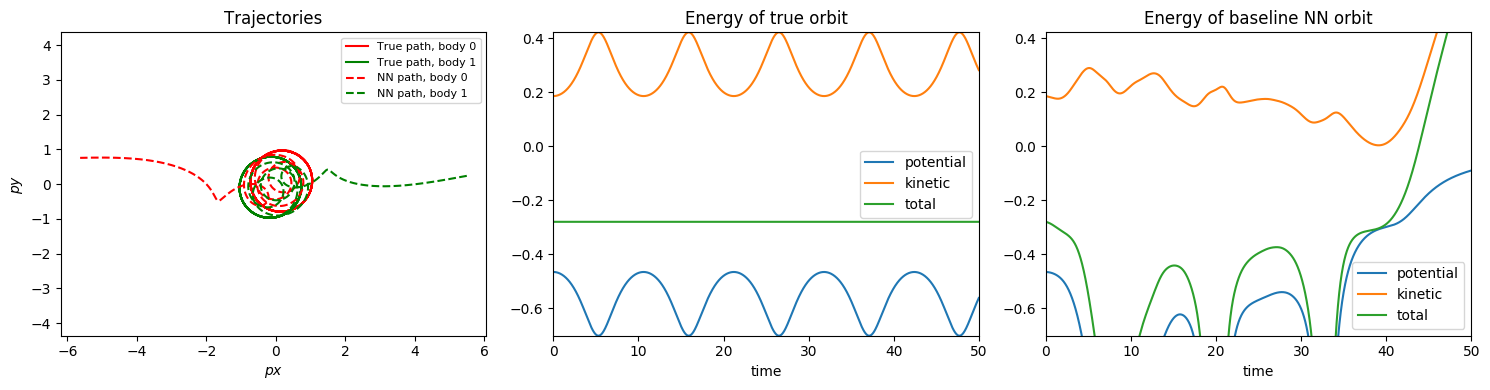

In [7]:
fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories')
colors = ['r', 'g', 'b']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i))
    
for i, path in enumerate(base_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i))

plt.axis('equal')
plt.xlabel('$px$') ; plt.ylabel('$py$')
plt.legend(fontsize=8)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Energy of true orbit') ; plt.xlabel('time')
plt.plot(settings['t_eval'], real_pe, label='potential')
plt.plot(settings['t_eval'], real_ke, label='kinetic')
plt.plot(settings['t_eval'], real_etot, label='total')
plt.legend()
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Energy of baseline NN orbit') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(base_orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(base_orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(base_orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-base-example.{}'.format(args.fig_dir, FORMAT))

## What has the HNN learned?

### Integrate trajectories

In [8]:
np.random.seed(2)
t_points = 2000
t_span = [0,50]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update(t, y0, hnn_model)
hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

### Draw trajectories

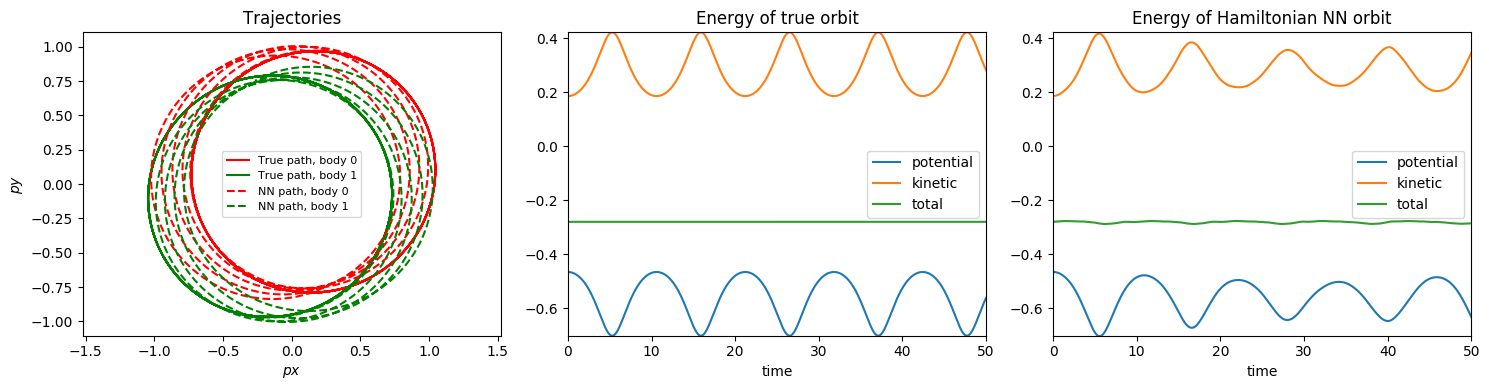

In [9]:
fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories')
colors = ['r', 'g', 'b']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i))
    
for i, path in enumerate(hnn_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i))

plt.axis('equal')
plt.xlabel('$px$') ; plt.ylabel('$py$')
plt.legend(fontsize=8)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Energy of true orbit') ; plt.xlabel('time')
plt.plot(settings['t_eval'], real_pe, label='potential')
plt.plot(settings['t_eval'], real_ke, label='kinetic')
plt.plot(settings['t_eval'], real_etot, label='total')
plt.legend()
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Energy of Hamiltonian NN orbit') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(hnn_orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(hnn_orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(hnn_orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-hnn-example.{}'.format(args.fig_dir, FORMAT))

## How does the HNN's scalar output behave?

In [10]:
# integrate trajectories
t_points = 100
t_span = [0,10]
num_orbits = 50
update_fn = lambda t, y0: model_update(t, y0, hnn_model)

orbits = []
energies = []
for i in range(num_orbits):
    np.random.seed(i)
    state = random_config()
    mini_orbit, _ = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    orbits.append(mini_orbit)
    
    # convert from state to canonical coords
    np_coords = mini_orbit[:,1:,:].transpose(1,0,2).reshape(8, -1).T
    coords = torch.tensor( np_coords, requires_grad=True, dtype=torch.float32)
    F1, F2 = hnn_model.forward(coords)
    energies.append(F2.data.numpy().squeeze())

energies = np.stack(energies)
e_order = np.argsort(energies.mean(1))
energies = energies[e_order]

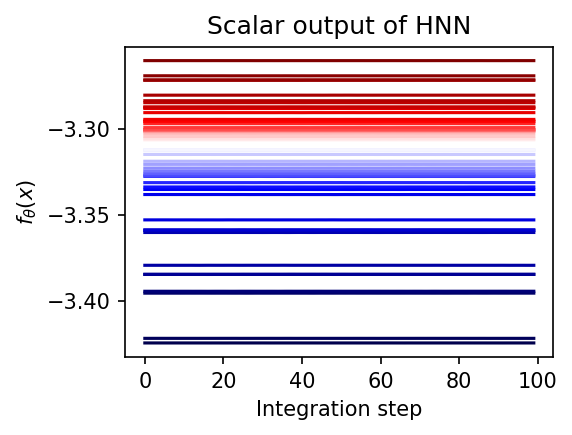

In [18]:
fig = plt.figure(figsize=[4,3], dpi=150)
plt.subplot(1,1,1)

import matplotlib.pylab as pl
colors = pl.cm.seismic(np.linspace(0,1,num_orbits))
for i, e in enumerate(energies):
    plt.plot(e, color=colors[i])
    
plt.xlabel('Integration step')
plt.ylabel('$f_{\\theta}(x)$')
plt.title("Scalar output of HNN")
plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-hnn-energy-distribution.{}'.format(args.fig_dir, FORMAT))

## Let's make a GIF to visualize the three orbits
* Ground truth
* Hamiltonian NN
* Baseline NN

In [12]:
def plot_orbits(fig, k, tail=100, pfrac=0.05, fs=28, ms=40, lw=3, tpad=15):
    xmin = ymin = np.min([orbit[:,1,:].min(), orbit[:,2,:].min()])
    xmax = ymax = np.max([orbit[:,1,:].max(), orbit[:,2,:].max()])
    pad = (xmax-xmin)*pfrac
    xmin -= pad
    xmax += pad
    ymin -= pad
    ymax += pad

    colors = ['r', 'g', 'b']
    t = max(0, k-tail)

    plt.subplot(1,3,1)
    plt.title('Ground truth', fontsize=fs, pad=tpad)
    for i, path in enumerate(orbit):
        plt.plot(path[1,t:k], path[2,t:k], '-', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
    plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    plt.subplot(1,3,2)
    plt.title('Hamiltonian NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(hnn_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '-', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
    plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    plt.subplot(1,3,3)
    plt.title('Baseline NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(base_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '-', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
    plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')
    
    plt.tight_layout()

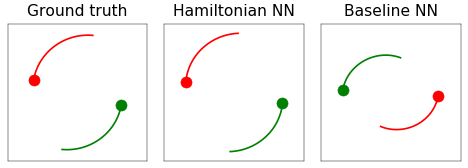

In [13]:
dpi = 40
k = 600
fig = plt.figure(figsize=[11.8,4.3], dpi=dpi)
plot_orbits(fig, k)
plt.show()

In [14]:
# get a rollout of the policy
movie_title = "orbits-compare.gif"
dpi = 40
num_frames = 150
num_steps = 900
print('\tmaking movie')

# make the movie!
start = time.time()
# FFMpegWriter = animation.writers['ffmpeg']
# metadata = dict(title=movie_title, artist='greydanus', comment='test-video')
# writer = FFMpegWriter(fps=8, metadata=metadata)

metadata = dict(title=movie_title, artist='greydanus', comment='Orbit demo for hnn paper')
writer = animation.ImageMagickWriter(fps=8, metadata=metadata)

prog = ''
f = plt.figure(figsize=[11.8,4.3], dpi=dpi)
with writer.saving(f, '{}/{}'.format(args.fig_dir, movie_title), dpi):
    for i in range(num_frames):
        
        orbit_step = int(i*num_steps/num_frames)
        plot_orbits(fig, k=orbit_step)
        writer.grab_frame() ; f.clear()

        tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
        print('\ttime: {} | orbit_t={:.0f} | progress: {:.1f}%'
              .format(tstr, orbit_step, 100.*i/num_frames), end='\r')
print('\nfinished.')

	making movie
	time: 00h 00m 20s | orbit_t=894 | progress: 99.3%
finished.


<Figure size 472x172 with 0 Axes>

## How well does the HNN conserve energy vs. the baseline?

In [15]:
t_points = 500
t_span = [0,25]
trials = 16

true_energies, base_energies, hnn_energies = [], [], []
for trial_ix in range(trials):
    
    np.random.seed(trial_ix)
    state = random_config()
    
    # true trajectory -> energy
    orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)
    true_energies.append(total_energy(orbit))
    
    # baseline NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, base_model)
    base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    base_energies.append(total_energy(base_orbit))
    
    # hamiltonian NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, hnn_model)
    hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    hnn_energies.append(total_energy(hnn_orbit))
    
true_energies = np.stack(true_energies)
base_energies = np.stack(base_energies)
hnn_energies = np.stack(hnn_energies)

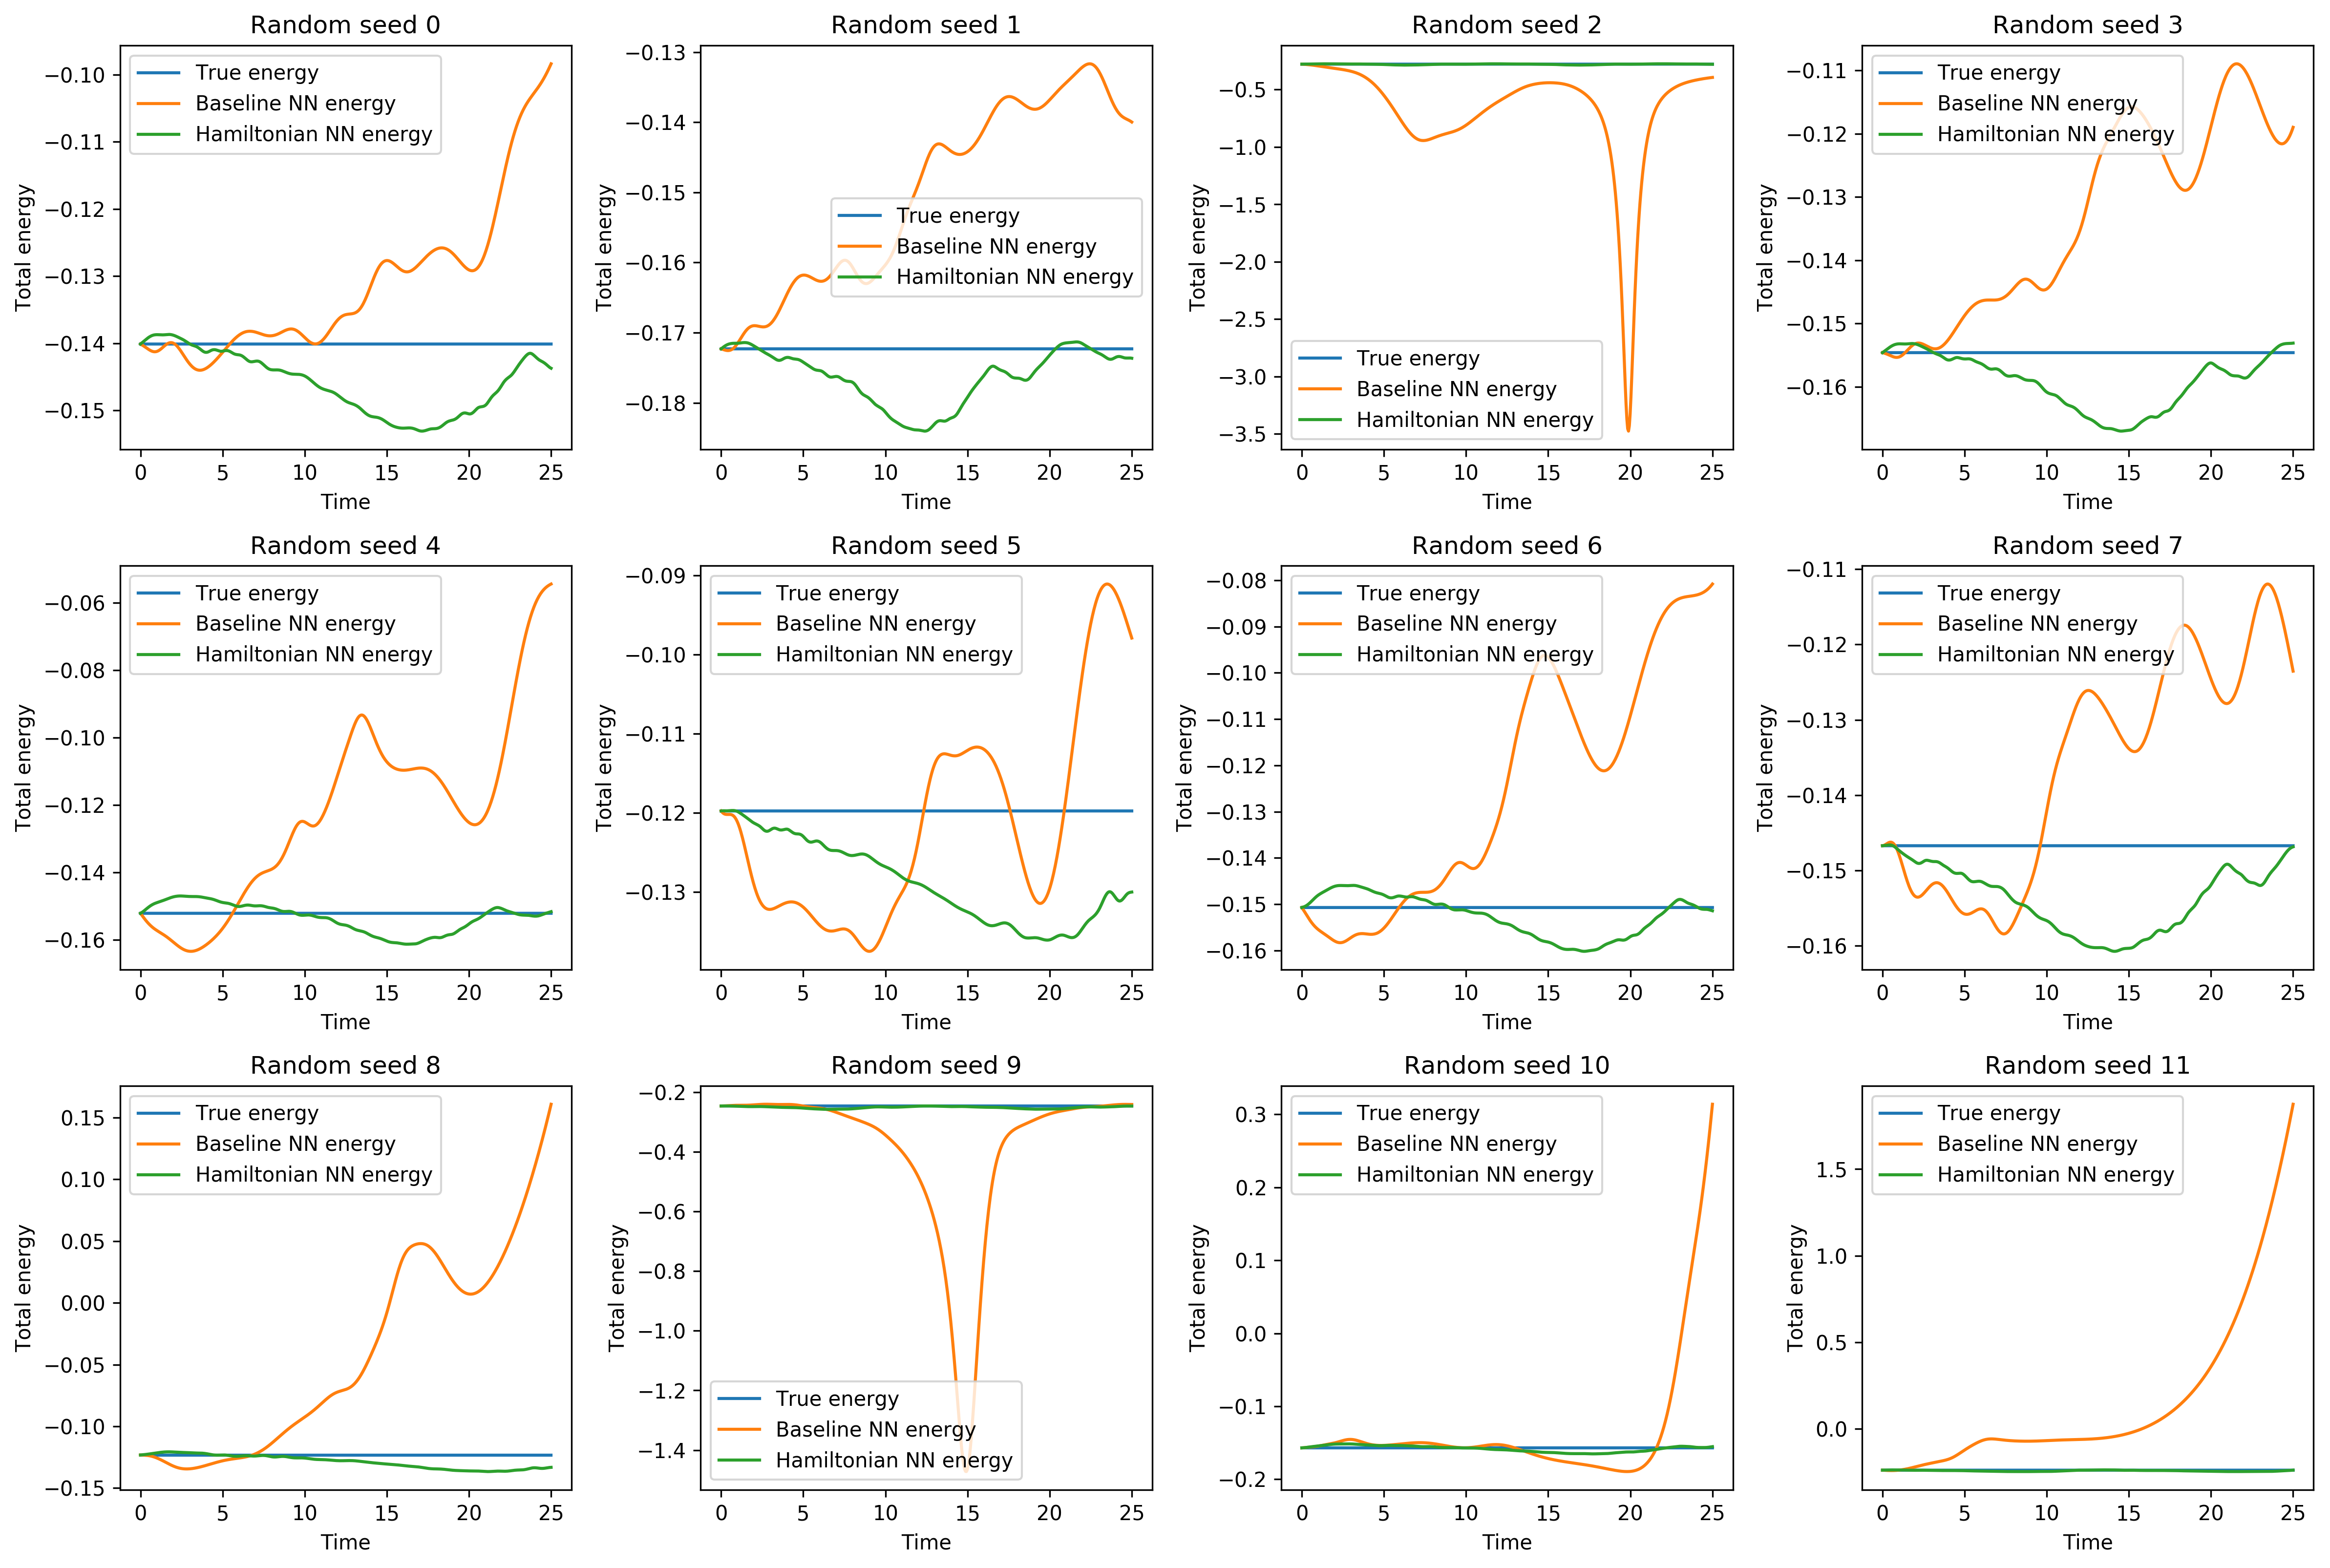

In [16]:
rows, cols = 3, 4
N = rows*cols
s = 4
fig = plt.figure(figsize=[cols*s, .9*rows*s], dpi=DPI)
for i in range(N):
    
    plt.subplot(rows, cols,i+1)
    t_domain = np.linspace(t_span[0], t_span[1], t_points)
    plt.title('Random seed {}'.format(i))
    plt.plot(t_domain, true_energies[i], label='True energy')
    plt.plot(t_domain, base_energies[i], label='Baseline NN energy')
    plt.plot(t_domain, hnn_energies[i], label='Hamiltonian NN energy')
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    plt.legend()
    
plt.tight_layout() ; plt.show()
fig.savefig('{}/orbits-total-energy.{}'.format(args.fig_dir, FORMAT))

In [17]:
print('Baseline NN energy MSE: {:.3e}'.format(np.mean((true_energies - base_energies)**2)))
print('Hamiltonian NN energy MSE: {:.3e}'.format(np.mean((true_energies - hnn_energies)**2)))

Baseline NN energy MSE: 5.933e-02
Hamiltonian NN energy MSE: 3.801e-05
